In [87]:
import numpy as np
import matplotlib.pyplot as plt
from src.cyc_gbm import CycGBM
from src.cyc_gbm.distributions import initiate_distribution
from scipy.optimize import minimize

In [88]:
# Simulator
rng = np.random.default_rng(seed =10)
distribution = initiate_distribution(dist = 'neg_bin')
p = 9
n = 1000
X = np.concatenate([np.ones((1, n)), rng.normal(0, 1, (p - 1, n))]).T
z0 = -1 +0.004*np.minimum(2,X[:,4])**2 + 2.2*np.minimum(0.5,X[:,1])+np.sin(0.3*X[:,2])
z1 = -2+0.3*(X[:,1]>0) + 0.2*np.abs(X[:,2])*(X[:,5]>0) + 0.2*X[:,3]
z = np.stack([z0,z1])
y = distribution.simulate(z, random_state = 11)

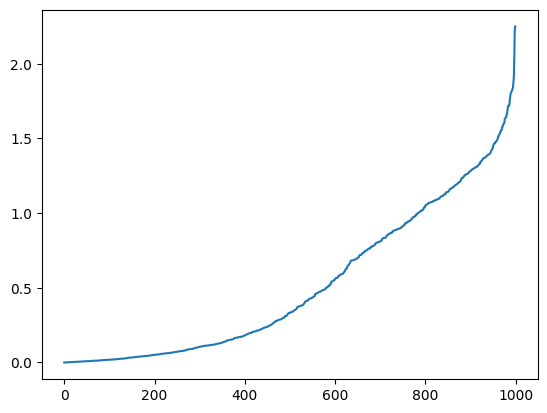

In [89]:
mu = distribution.moment(z = z, k = 1)

mu_sort = np.sort(mu)
plt.plot(mu_sort)

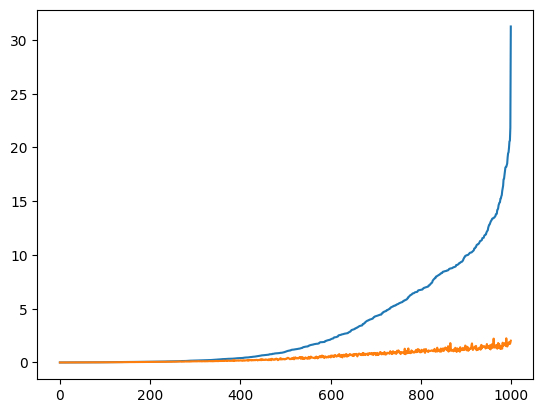

In [90]:
var = distribution.moment(z = z, k = 2)
sort_order = np.argsort(var)
plt.plot(var[sort_order])
plt.plot(mu[sort_order])

In [91]:
# Set hyperparameters
kappa = [1000,1000]
max_depth = 2
min_samples_leaf = 10
eps = [0.1, 0.1]

In [92]:
gbm = CycGBM(
    kappa=kappa,
    eps=eps,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    dist="neg_bin",
)
gbm.fit(X, y)
z_hat_new = gbm.predict(X)

In [93]:
# Conversion to old structure
zOpt = gbm.z0
BOpts = kappa
BOpt = max(kappa)
d = 2
epsilon = eps

In [94]:
# Distribution dependent
from scipy.special import polygamma as pg
from scipy.special import loggamma as lg


# Loss function
def lossEval(z, y):
    return distribution.loss(z=z, y=y)


# Gradients
def grad0(z, y):
    return distribution.grad(z=z, y=y, j=0)


def grad1(z, y):
    return distribution.grad(z=z, y=y, j=1)


# Gradient list
grads = [grad0, grad1]

In [95]:
# Setup
from sklearn.tree import DecisionTreeRegressor as regressionTree


# Tree fitting function
def trainTree(z, y, x, grad, max_depth, min_samples_leaf):
    tree = regressionTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    g = grad(z, y)
    tree.fit(x, -g)
    return tree


# Dimension indicator for score adding
e = [np.stack([[0]] * j + [[1]] + [[0]] * (d - j - 1)) for j in range(0, d)]


# Local tree training function
def trainThisTree(z, y, x, grad, max_depth, min_samples_leaf):
    return trainTree(
        z=z, y=y, x=x, grad=grad, max_depth=max_depth, min_samples_leaf=min_samples_leaf
    )

In [96]:
# Training and validation data
xTrain, yTrain = X, y
xValid, yValid = X, y
nTrain, nValid = len(yTrain), len(yValid)

# Initiate score
zTrain = zOpt.repeat(nTrain).reshape((d, nTrain))
zValid = zOpt.repeat(nValid).reshape((d, nValid))

trees = [[[]] * BOpts[0], [[]] * BOpts[1]]

# Build trees
for b in range(0, BOpt):
    # For all parameter dimensions
    for j in range(0, d):
        if b < BOpts[j]:
            # Fit a tree
            tree = trainThisTree(
                zTrain,
                yTrain,
                xTrain,
                grads[j],
                max_depth=max_depth,
                min_samples_leaf=min_samples_leaf,
            )

            # Score updates
            zTrainPlus = tree.predict(xTrain)
            zValidPlus = tree.predict(xValid)

            # Look at all unique node values
            nodeValues = np.unique(zTrainPlus)
            for nodeValue in nodeValues:
                # Indices with this node value
                indicesTrain = zTrainPlus == nodeValue
                indicesValid = zValidPlus == nodeValue
                # Optimize step size
                # gammaOpt = minimize(
                #     fun = lambda gamma: lossEval( z=zTrain[:, indicesTrain] + e[j] * gamma, y=yTrain[indicesTrain] ).sum(),
                #     jac = lambda gamma: -grad0(z=zTrain[:, indicesTrain] + e[j] * gamma, y=yTrain[indicesTrain]).sum(),
                #     bounds = [(0, 1000)],
                #     x0=nodeValue,
                # )["x"][0]
                gammaOpt = distribution.opt_step(z = zTrain[:, indicesTrain], y = yTrain[indicesTrain], j = j, g_0 = nodeValue)
                # Manipulate node values
                zTrainPlus[indicesTrain] = gammaOpt
                zValidPlus[indicesValid] = gammaOpt
                tree.tree_.value[tree.tree_.value == nodeValue] = gammaOpt

            # Update score
            zTrain[j] += epsilon[j] * zTrainPlus
            zValid[j] += epsilon[j] * zValidPlus

            # Update trees
            trees[j][b] = tree

In [97]:
# Assume two dimensions
z_hat_old = zOpt.repeat(nTrain).reshape((d, nTrain))
for j in [0, 1]:
    z_hat_j = epsilon[j] * sum([tree.predict(X) for tree in trees[j]])
    z_hat_old[j] += z_hat_j

In [98]:
print(f"intercept loss: {gbm.dist.loss(y = y, z =gbm.z0).sum().round(2)}")
print(f"old model loss: {gbm.dist.loss(y = y, z = z_hat_old).sum().round(2)}")
print(f"new model loss: {gbm.dist.loss(y = y, z = z_hat_new).sum().round(2)}")

intercept loss: 289.82
old model loss: -198.59
new model loss: -198.59


/tmp/ipykernel_1715249/1833971702.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(y)[sort_order])


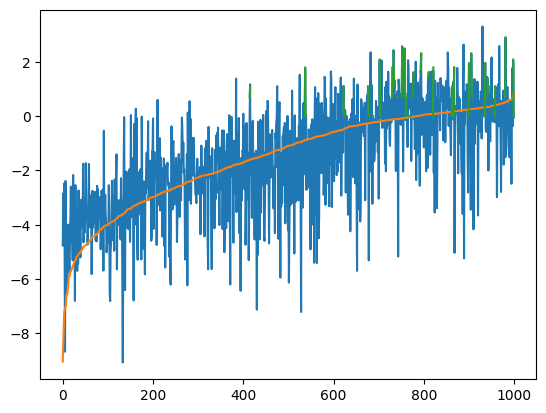

In [99]:
sort_order = np.argsort(z[0])
plt.plot(z_hat_new[0][sort_order])
plt.plot(z[0][sort_order])
plt.plot(np.log(y)[sort_order])

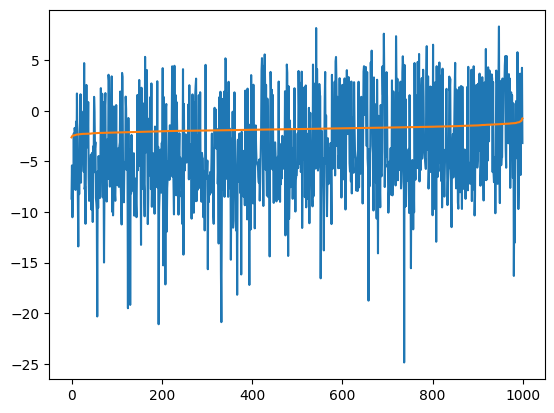

In [100]:
sort_order = np.argsort(z[1])
plt.plot(z_hat_new[1][sort_order])
plt.plot(z[1][sort_order])

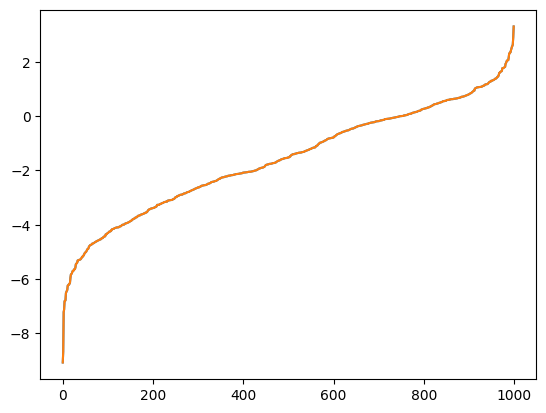

In [101]:
sort_order = np.argsort(z_hat_new[0])
plt.plot(z_hat_new[0][sort_order])
plt.plot(z_hat_old[0][sort_order])

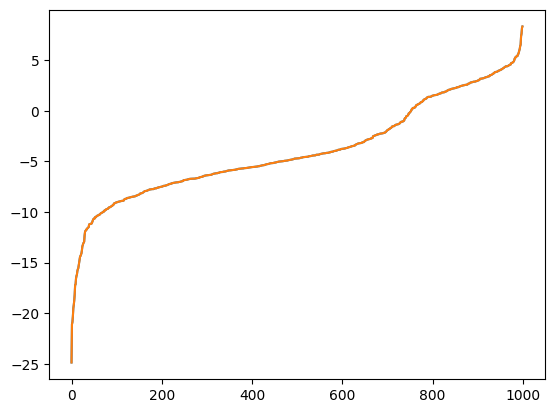

In [102]:
sort_order = np.argsort(z_hat_new[1])
plt.plot(z_hat_new[1][sort_order])
plt.plot(z_hat_old[1][sort_order])
